In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

<module 'libs.models' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,vwap_dev_15,bb_width_15,vol_15,rsi_15,stoch_k_15,plus_di_15,r_15,bid,ask,signal
2004-01-02 13:09:00,-0.040178,-1.574415,-1.470597,-2.557298,-1.785354,-1.346141,-0.025470,0.763664,0.764807,0.021536
2004-01-02 13:10:00,-0.048980,-1.545814,-1.466297,-2.557298,-1.785354,-1.346141,-0.033444,0.763647,0.764790,0.023284
2004-01-02 13:11:00,-0.056140,-1.516045,-1.463327,-2.557298,-1.785354,-1.346141,-0.041417,0.763631,0.764773,0.025175
2004-01-02 13:12:00,-0.061878,-1.485916,-1.461447,-2.557298,-1.785354,-1.346141,-0.049391,0.763614,0.764757,0.027222
2004-01-02 13:13:00,-0.066452,-1.456142,-1.460532,-2.557298,-1.785354,-1.346141,-0.057365,0.763597,0.764740,0.029436
...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,1.066747,0.844220,0.884708,0.726751,0.700633,0.573679,1.323284,196.667400,196.962600,0.684908
2025-06-18 20:57:00,0.436767,0.825992,0.942109,0.484027,0.361998,0.495133,1.119932,196.527500,196.822500,0.612206
2025-06-18 20:58:00,0.331541,0.848628,0.919047,0.475468,0.340989,0.440310,0.832284,196.522500,196.817500,0.610468
2025-06-18 20:59:00,-1.002846,0.866409,1.231640,-0.145922,-0.857130,0.210130,-0.094278,196.092800,196.387200,0.477090


In [4]:
# Build LSTM input tensors (disk-backed memmaps)
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape, "(samples,)")
print("  y_ret     =", y_ret.shape, "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Inside build_lstm_tensors, using: ['vwap_dev_15', 'bb_width_15', 'vol_15', 'rsi_15', 'stoch_k_15', 'plus_di_15', 'r_15']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2419779, 60, 7]) (samples, look_back, features)
  y_sig     = torch.Size([2419779]) (samples,)
  y_ret     = torch.Size([2419779]) (samples,)
  raw_close = torch.Size([2419779])
  raw_bid   = torch.Size([2419779])
  raw_ask   = torch.Size([2419779])
  end_times = (2419779,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1716386, 60, 7])
  y_sig_tr, y_ret_tr = torch.Size([1716386]) torch.Size([1716386])
  X_val = torch.Size([338701, 60, 7])
  y_sig_val, y_ret_val = torch.Size([338701]) torch.Size([338701])
  X_te  = torch.Size([364692, 60, 7])
  y_sig_te, y_ret_te = torch.Size([364692]) torch.Size([364692])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days  → train=3840, val=751, test=809
Batches → train=60,   val=751,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = X.shape[-1],                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(params.device)  

model

DualMemoryLSTM(
  (conv): Conv1d(7, 7, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(7, 32, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (do_short): Dropout(p=0.2, inplace=False)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(64, 32, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.2, inplace=False)
  (ln_long): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=64, out_features=1, bias=True)
  (cls_head): Linear(in_features=64, out_features=1, bias=True)
  (cls_ter): Linear(in_features=64, out_features=3, bias=True)
)

In [8]:
# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 5e-05
    lr: 5e-05
    maximize: False
    weight_decay: 5e-05
)

In [9]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.404006,  val = 0.409382

Train target stats:
  mean = 0.2811,  var = 0.0842,  std = 0.2901
Train mean‐predictor baseline:
  RMSE_baseline = 0.290139
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.2919,  var = 0.0824,  std = 0.2870
Validation mean‐predictor baseline:
  RMSE_baseline = 0.287012
  R²_baseline   = 0.00



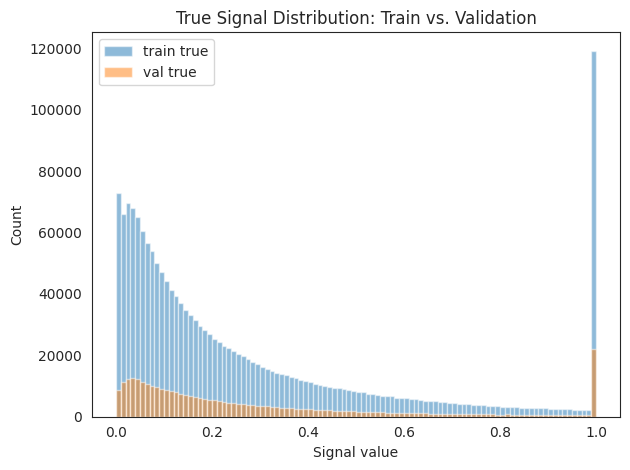

In [10]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3840 unique trading days per epoch.



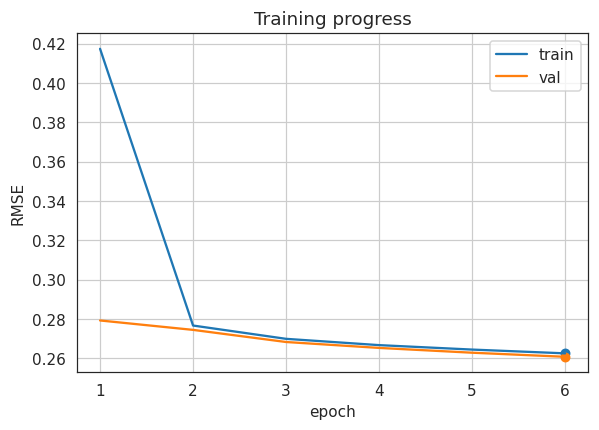

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.4173 MAE=0.3711 R2=-1.0681 | "B": Acc=0.6570 Prec=0.3370 Rec=0.2478 F1=0.2856 AUROC=0.5544
VALID→ "R": RMSE=0.2792 MAE=0.2249 R2=0.0538 | "B": Acc=0.7056 Prec=0.4683 Rec=0.1825 F1=0.2626 AUROC=0.6552


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2766 MAE=0.2155 R2=0.0915 | "B": Acc=0.5806 Prec=0.2955 Rec=0.3730 F1=0.3298 AUROC=0.5215
VALID→ "R": RMSE=0.2744 MAE=0.1907 R2=0.0859 | "B": Acc=0.5551 Prec=0.2508 Rec=0.2760 F1=0.2628 AUROC=0.4322


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2699 MAE=0.2050 R2=0.1354 | "B": Acc=0.5285 Prec=0.2786 Rec=0.4432 F1=0.3421 AUROC=0.5026
VALID→ "R": RMSE=0.2682 MAE=0.1881 R2=0.1265 | "B": Acc=0.5078 Prec=0.2720 Rec=0.4254 F1=0.3318 AUROC=0.4977


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2667 MAE=0.2039 R2=0.1557 | "B": Acc=0.5140 Prec=0.2893 Rec=0.5195 F1=0.3716 AUROC=0.5215
VALID→ "R": RMSE=0.2652 MAE=0.1866 R2=0.1460 | "B": Acc=0.4797 Prec=0.2974 Rec=0.5949 F1=0.3965 AUROC=0.5322


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2644 MAE=0.2025 R2=0.1700 | "B": Acc=0.4912 Prec=0.2909 Rec=0.5837 F1=0.3882 AUROC=0.5278
VALID→ "R": RMSE=0.2628 MAE=0.1853 R2=0.1616 | "B": Acc=0.4536 Prec=0.3006 Rec=0.6798 F1=0.4169 AUROC=0.5404


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2625 MAE=0.2013 R2=0.1820 | "B": Acc=0.4627 Prec=0.2879 Rec=0.6394 F1=0.3970 AUROC=0.5263
VALID→ "R": RMSE=0.2607 MAE=0.1841 R2=0.1748 | "B": Acc=0.4248 Prec=0.2956 Rec=0.7248 F1=0.4200 AUROC=0.5319


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

In [ ]:
# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")

